# Importation des biblio

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#import face_recognition
import warnings
warnings.filterwarnings('ignore') 
import cv2
import os
import numpy as np
import dlib
import matplotlib.pyplot as plt

from skimage.transform import resize
import math
from skimage.feature import hog
from sklearn.svm import SVC,LinearSVC
from typing import List
from PIL import Image
from sklearn.model_selection import train_test_split
from skimage import io
from skimage.color import rgb2gray
from sklearn.naive_bayes import GaussianNB

from tqdm import tqdm

# Fonction retournant les liens des images et les labels

In [ ]:

path = '/content/drive/MyDrive/Projet S2/dataset3/train'

def _get_data(path):
    class_names = os.listdir(path)
    image_paths = []
    labels = []
    for name in class_names:
        directory = os.path.join(path, name)
        #directory = path + "/" + name
        #print(directory)
        class_path = [os.path.join(directory, f) for f in os.listdir(directory)]
        #class_path = [directory + "/" + f for f in os.listdir(directory)]
        image_paths += class_path
        labels.extend([name] * len(class_path))
    return image_paths, labels




def get_training_data():
    return _get_data('/content/drive/MyDrive/Projet S2/dataset3/Data_ANN/train')


def get_test_data():
    return _get_data('/content/drive/MyDrive/Projet S2/dataset3/Data_ANN/test')


# Pour tester la fonction

# if __name__ == "__main__":
#     print(get_training_data())



# Détection des visages avec dlib

In [ ]:
def Visage_dlib(images_path,labels):
    #eyescas = cv2.CascadeClassifier('/home/abs/Téléchargements/projet s2/opencv-3.4/data/haarcascades/haarcascade_eye_tree_eyeglasses.xml')
    #mouthcas = cv2.CascadeClassifier('/home/abs/Téléchargements/projet s2/Face-Detection-Recognition-Using-OpenCV-in-Python-master/Mouth.xml')
    visages = []
    Labels = []
    j = 0
    hogFaceDetector = dlib.get_frontal_face_detector()
    for lien_img in images_path:
        image = cv2.imread(lien_img)
          # print(image.shape)
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        faces = hogFaceDetector(gray, 1)
        if len(faces) != 0:
            for (i, rect) in enumerate(faces):
                x = rect.left()
                y = rect.top()
                w = rect.right() - x
                h = rect.bottom() - y
                cv2.rectangle(image, (x, y), (x + w, y + h), (0, 0, 0), 1)
                face = image[y:y+h, x:x+w]
                #faces_eye = eyescas.detectMultiScale(face, 1.3, 10)
                #for (xe, ye, we, he)  in faces_eye:
                 #   cv2.rectangle(face, (xe, ye), (xe+we, ye+he), (255, 0, 0), 1) 
                #faces_mouth = mouthcas.detectMultiScale(face, 1.4, 10)
                #for (xm, ym, wm, hm)  in faces_mouth:
                 #   cv2.rectangle(face, (xm, ym), (xm+wm, ym+hm), (255, 0, 0), 1)     
                visages.append(face)
                Labels.append(labels[j])
        j+=1  
    return visages, Labels

In [ ]:
# I1,L1 = Visage_dlib(I1,L1)

In [ ]:
testface, testlab = Visage_dlib(['/content/gettyimages-461555268-594x594.jpg'],'Katrina' )

In [ ]:
# print('taille I1:', len(I1))
# print('taille L1:', len(L1))

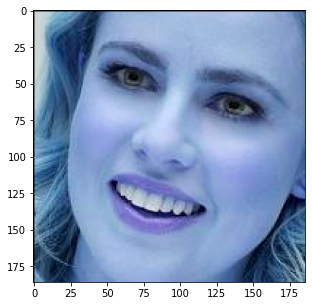

In [ ]:
# i = 3
plt.figure(figsize=(5,5))
# plt.subplot(121)
plt.imshow(testface[0])
# plt.subplot(122)
# plt.imshow(I1[i+1])

100%|██████████| 1/1 [00:00<00:00, 292.41it/s]


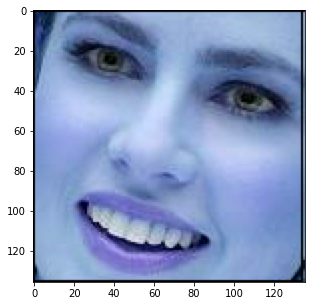

In [ ]:
faces_ilbp,labels_ilbp  = Visage_detect_cascade(testface, testlab)
plt.figure(figsize=(5,5))
plt.imshow(faces_ilbp[0])


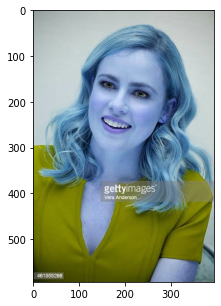

In [ ]:
plt.figure(figsize=(5,5))
plt.imshow(cv2.imread('/content/gettyimages-461555268-594x594.jpg'))

# Alignement de visages 

In [ ]:
%%file facial_feature_detector.py

import dlib
import os
import numpy as np

this_path = os.path.dirname(__file__)

def _shape_to_np(shape):
    xy = []
    for i in range(68):
        xy.append((shape.part(i).x, shape.part(i).y,))
    xy = np.asarray(xy, dtype='float32')
    return xy


def get_landmarks(img):
    # if not automatically downloaded, get it from:
    # http://sourceforge.net/projects/dclib/files/dlib/v18.10/shape_predictor_68_face_landmarks.dat.bz2
    #predictor_path = "shape_predictor_68_face_landmarks.dat"
    detector = dlib.get_frontal_face_detector()
    predictor = dlib.shape_predictor('/content/drive/MyDrive/Projet S2/shape_predictor_68_face_landmarks.dat')

    lmarks = []
    dets = detector(img, 1)
   # print("Number of faces detected: {}".format(len(dets)))
    shapes = []
    for k, det in enumerate(dets):
        shape = predictor(img, det)
        shapes.append(shape)
        xy = _shape_to_np(shape)
        lmarks.append(xy)

    lmarks = np.asarray(lmarks, dtype='float32')
    # display_landmarks(img, dets, shapes)
    return lmarks


def display_landmarks(img, dets, shapes):
    win = dlib.image_window()
    win.clear_overlay()
    win.set_image(img)
    for shape in shapes:
        win.add_overlay(shape)
    win.add_overlay(dets)
    dlib.hit_enter_to_continue()

Writing facial_feature_detector.py


In [ ]:
%%file Camera_calibration.py

import numpy as np
import cv2


def estimate_camera(model3D, fidu_XY):
    rmat, tvec = calib_camera(model3D, fidu_XY)
    RT = np.hstack((rmat, tvec))
    projection_matrix = model3D.out_A * RT
    return projection_matrix, model3D.out_A, rmat, tvec


def calib_camera(model3D, fidu_XY):
    #compute pose using refrence 3D points + query 2D points
    ret, rvecs, tvec = cv2.solvePnP(model3D.model_TD, fidu_XY, model3D.out_A, None, None, None, False)
    rmat, jacobian = cv2.Rodrigues(rvecs, None)

    inside = calc_inside(model3D.out_A, rmat, tvec, model3D.size_U[0], model3D.size_U[1], model3D.model_TD)
    if(inside == 0):
        tvec = -tvec
        t = np.pi
        RRz180 = np.asmatrix([np.cos(t), -np.sin(t), 0, np.sin(t), np.cos(t), 0, 0, 0, 1]).reshape((3, 3))
        rmat = RRz180*rmat
    return rmat, tvec


def get_opengl_matrices(camera_matrix, rmat, tvec, width, height):
    projection_matrix = np.asmatrix(np.zeros((4,4)))
    near_plane = 0.0001
    far_plane = 10000

    fx = camera_matrix[0,0]
    fy = camera_matrix[1,1]
    px = camera_matrix[0,2]
    py = camera_matrix[1,2]

    projection_matrix[0, 0] = 2.0 * fx / width
    projection_matrix[1, 1] = 2.0 * fy / height
    projection_matrix[0, 2] = 2.0 * (px / width) - 1.0
    projection_matrix[1, 2] = 2.0 * (py / height) - 1.0
    projection_matrix[2, 2] = -(far_plane + near_plane) / (far_plane - near_plane)
    projection_matrix[3, 2] = -1
    projection_matrix[2, 3] = -2.0 * far_plane * near_plane / (far_plane - near_plane)

    deg = 180
    t = deg*np.pi/180.
    RRz=np.asmatrix([np.cos(t), -np.sin(t), 0, np.sin(t), np.cos(t), 0, 0, 0, 1]).reshape((3, 3))
    RRy=np.asmatrix([np.cos(t), 0, np.sin(t), 0, 1, 0, -np.sin(t), 0, np.cos(t)]).reshape((3, 3))
    rmat=RRz*RRy*rmat

    mv = np.asmatrix(np.zeros((4, 4)))
    mv[0:3, 0:3] = rmat
    mv[0, 3] = tvec[0]
    mv[1, 3] = -tvec[1]
    mv[2, 3] = -tvec[2]
    mv[3, 3] = 1.
    return mv, projection_matrix


def extract_frustum(camera_matrix, rmat, tvec, width, height):
    mv, proj = get_opengl_matrices(camera_matrix, rmat, tvec, width, height)
    clip = proj * mv
    frustum = np.asmatrix(np.zeros((6 ,4)))
    #/* Extract the numbers for the RIGHT plane */
    frustum[0, :] = clip[3, :] - clip[0, :]
    #/* Normalize the result */
    v = frustum[0, :3]
    t = np.sqrt(np.sum(np.multiply(v, v)))
    frustum[0, :] = frustum[0, :]/t

    #/* Extract the numbers for the LEFT plane */
    frustum[1, :] = clip[3, :] + clip[0, :]
    #/* Normalize the result */
    v = frustum[1, :3]
    t = np.sqrt(np.sum(np.multiply(v, v)))
    frustum[1, :] = frustum[1, :]/t

    #/* Extract the BOTTOM plane */
    frustum[2, :] = clip[3, :] + clip[1, :]
    #/* Normalize the result */
    v = frustum[2, :3]
    t = np.sqrt(np.sum(np.multiply(v, v)))
    frustum[2, :] = frustum[2, :]/t

    #/* Extract the TOP plane */
    frustum[3, :] = clip[3, :] - clip[1, :]
    #/* Normalize the result */
    v = frustum[3, :3]
    t = np.sqrt(np.sum(np.multiply(v, v)))
    frustum[3, :] = frustum[3, :]/t

    #/* Extract the FAR plane */
    frustum[4, :] = clip[3, :] - clip[2, :]
    #/* Normalize the result */
    v = frustum[4, :3]
    t = np.sqrt(np.sum(np.multiply(v, v)))
    frustum[4, :] = frustum[4, :]/t

    #/* Extract the NEAR plane */
    frustum[5, :] = clip[3, :] + clip[2, :]
    #/* Normalize the result */
    v = frustum[5, :3]
    t = np.sqrt(np.sum(np.multiply(v, v)))
    frustum[5, :] = frustum[5, :]/t
    return frustum


def calc_inside(camera_matrix, rmat, tvec, width, height, obj_points):
    frustum = extract_frustum(camera_matrix, rmat, tvec, width, height)
    inside = 0
    for point in obj_points:
        if(point_in_frustum(point[0], point[1], point[2], frustum) > 0):
            inside += 1
    return inside


def point_in_frustum(x, y, z, frustum):
    for p in range(0, 3):
        if(frustum[p, 0] * x + frustum[p, 1] * y + frustum[p, 2] + z + frustum[p, 3] <= 0):
            return False
    return True

Writing Camera_calibration.py


In [ ]:
%%file trt_IMAGE.py
import scipy.io as scio
import numpy as np
import cv2
import dlib
from imutils.face_utils import FaceAligner
from imutils.face_utils import rect_to_bb
import imutils
import matplotlib.pyplot as plt


class ThreeD_Model:
    def __init__(self, path, name):
        self.load_model(path, name)

    def load_model(self, path, name):
        model = scio.loadmat(path)[name]
        self.out_A = np.asmatrix(model['outA'][0, 0], dtype='float32') #3x3
        self.size_U = model['sizeU'][0, 0][0] #1x2
        self.model_TD = np.asarray(model['threedee'][0,0], dtype='float32') #68x3
        self.indbad = model['indbad'][0, 0]#0x1
        self.ref_U = np.asarray(model['refU'][0,0])

def dlibLandmarksToPoints(shape):
  points = []
  for p in shape.parts():
    pt = (p.x, p.y)
    points.append(pt)
  return points

# detect facial landmarks in image
def getLandmarks(faceDetector, landmarkDetector, im, FACE_DOWNSAMPLE_RATIO = 1):
  points = []
  imSmall = cv2.resize(im,None,
                       fx=1.0/FACE_DOWNSAMPLE_RATIO, 
                       fy=1.0/FACE_DOWNSAMPLE_RATIO, 
                       interpolation = cv2.INTER_LINEAR)
  
  faceRects = faceDetector(imSmall, 0)
  
  if len(faceRects) > 0:
    maxArea = 0
    maxRect = None
    # TODO: test on images with multiple faces
    for face in faceRects:
      if face.area() > maxArea:
        maxArea = face.area()
        maxRect = [face.left(),
                   face.top(),
                   face.right(),
                   face.bottom()
                  ]
    
    rect = dlib.rectangle(*maxRect)
    scaledRect = dlib.rectangle(int(rect.left()*FACE_DOWNSAMPLE_RATIO),
                             int(rect.top()*FACE_DOWNSAMPLE_RATIO),
                             int(rect.right()*FACE_DOWNSAMPLE_RATIO),
                             int(rect.bottom()*FACE_DOWNSAMPLE_RATIO))
    
    landmarks = landmarkDetector(im, scaledRect)
    points = dlibLandmarksToPoints(landmarks)
  return points


# def get_face(image):
#     detector = dlib.get_frontal_face_detector()
#     predictor = dlib.shape_predictor("/content/drive/MyDrive/Projet S2/shape_predictor_68_face_landmarks.dat")
#     points = getLandmarks(detector, predictor, image)
#     hullIndex = cv2.convexHull(np.array(points).astype(np.int32), returnPoints=False)
#     hull = []
#     for i in range(0, len(hullIndex)):
#         hull.append(points[hullIndex[i][0]])
#     hull8U = []
#     for i in range(0, len(hull)):
#         hull8U.append((hull[i][0], hull[i][1]))
#     imtemp = image.copy()
#     cv2.fillConvexPoly(imtemp, np.int32(hull8U), (0, 0, 0))
#     face = np.zeros(image.shape, dtype=image.dtype) 
#     h=image.shape[0]
#     w=image.shape[1]
#     for i in range(h):
#         for j in range(w):
#             face[i][j]=image[i][j]-imtemp[i][j]
#     return face

def get_landmark(img):
    # if not automatically downloaded, get it from:
    # http://sourceforge.net/projects/dclib/files/dlib/v18.10/shape_predictor_68_face_landmarks.dat.bz2
    #predictor_path = "shape_predictor_68_face_landmarks.dat"
    detector = dlib.get_frontal_face_detector()
    predictor = dlib.shape_predictor('/content/drive/MyDrive/Projet S2/shape_predictor_68_face_landmarks.dat')

    lmarks = []
    dets = detector(img, 1)
    #print("Number of faces detected: {}".format(len(dets)))
    shapes = []
    for k, det in enumerate(dets):
        shape = predictor(img, det)
        shapes.append(shape)
        xy = _shape_to_np(shape)
        lmarks.append(xy)

    lmarks = np.asarray(lmarks, dtype='float32')
    # display_landmarks(img, dets, shapes)
    return lmarks

def _shape_to_np(shape):
    xy = []
    for i in range(68):
        xy.append((shape.part(i).x, shape.part(i).y,))
    xy = np.asarray(xy, dtype='float32')
    return xy

def frontalize(img, proj_matrix, ref_U, eyemask):
    ACC_CONST = 800
    img = img.astype('float32')
    #print("query image shape:", img.shape)

    bgind = np.sum(np.abs(ref_U), 2) == 0
    # count the number of times each pixel in the query is accessed
    threedee = np.reshape(ref_U, (-1, 3), order='F').transpose()
    temp_proj = proj_matrix * np.vstack((threedee, np.ones((1, threedee.shape[1]))))
    temp_proj2 = np.divide(temp_proj[0:2, :], np.tile(temp_proj[2, :], (2,1)))

    bad = np.logical_or(temp_proj2.min(axis=0) < 1, temp_proj2[1, :] > img.shape[0])
    bad = np.logical_or(bad, temp_proj2[0, :] > img.shape[1])
    bad = np.logical_or(bad, bgind.reshape((-1), order='F'))
    bad = np.asarray(bad).reshape((-1), order='F')

    temp_proj2 -= 1

    badind = np.nonzero(bad > 0)[0]
    temp_proj2[:,badind] = 0

    ind = np.ravel_multi_index((np.asarray(temp_proj2[1, :].round(), dtype='int64'), np.asarray(temp_proj2[0, :].round(), dtype='int64')), dims=img.shape[:-1], order='F')

    synth_frontal_acc = np.zeros(ref_U.shape[:-1])
    ind_frontal = np.arange(0, ref_U.shape[0]*ref_U.shape[1])

    c, ic = np.unique(ind, return_inverse=True)
    bin_edges = np.r_[-np.Inf, 0.5 * (c[:-1] + c[1:]), np.Inf]
    count, bin_edges = np.histogram(ind, bin_edges)
    synth_frontal_acc = synth_frontal_acc.reshape(-1, order='F')
    synth_frontal_acc[ind_frontal] = count[ic]
    synth_frontal_acc = synth_frontal_acc.reshape((320, 320), order='F')
    synth_frontal_acc[bgind] = 0
    synth_frontal_acc = cv2.GaussianBlur(synth_frontal_acc, (15, 15), 30., borderType=cv2.BORDER_REPLICATE)

    #remap
    mapX = temp_proj2[0,:].astype(np.float32)
    mapY = temp_proj2[1,:].astype(np.float32)

    mapX = np.reshape(mapX,(-1,320), order = 'F')
    mapY = np.reshape(mapY,(-1,320), order = 'F')
    #visage1 = np.zeros(img.shape, dtype=img.dtype) 
    frontal_raw = cv2.remap(img, mapX, mapY, cv2.INTER_CUBIC)

    frontal_raw = frontal_raw.reshape((-1,3), order = 'F')
    frontal_raw[badind,:] = 0
    frontal_raw = frontal_raw.reshape((320, 320, 3), order = 'F')

    # which side has more occlusions?
    midcolumn = np.round(ref_U.shape[1]/2)
    sumaccs = synth_frontal_acc.sum(axis=0)
    sum_left = sumaccs[0:int(midcolumn)].sum()
    sum_right = sumaccs[int(midcolumn)+1:].sum()
    sum_diff = sum_left - sum_right
    
    if np.abs(sum_diff) > ACC_CONST:        # one side is ocluded
        ones = np.ones((int(ref_U.shape[0]), int(midcolumn)))
        zeros = np.zeros((int(ref_U.shape[0]), int(midcolumn)))
        if sum_diff > ACC_CONST: # left side of face has more occlusions
            weights = np.hstack((zeros, ones))
        else: # right side of face has more occlusions
            weights = np.hstack((ones, zeros))
        weights = cv2.GaussianBlur(weights, (33, 33), 60.5, borderType=cv2.BORDER_REPLICATE)

        # apply soft symmetry to use whatever parts are visible in ocluded side
        synth_frontal_acc /= synth_frontal_acc.max()
        weight_take_from_org = 1. / np.exp(0.5+synth_frontal_acc)
        weight_take_from_sym = 1 - weight_take_from_org

        weight_take_from_org = np.multiply(weight_take_from_org, np.fliplr(weights))
        weight_take_from_sym = np.multiply(weight_take_from_sym, np.fliplr(weights))

        weight_take_from_org = np.tile(weight_take_from_org.reshape(320, 320, 1), (1, 1, 3))
        weight_take_from_sym = np.tile(weight_take_from_sym.reshape(320, 320, 1), (1, 1, 3))
        weights = np.tile(weights.reshape(320, 320, 1), (1, 1, 3))

        denominator = weights + weight_take_from_org + weight_take_from_sym
        frontal_sym = np.multiply(frontal_raw, weights) + np.multiply(frontal_raw, weight_take_from_org) +  np.multiply(np.fliplr(frontal_raw), weight_take_from_sym)
        frontal_sym = np.divide(frontal_sym, denominator)

        # exclude eyes from symmetry
        frontal_sym = np.multiply(frontal_sym, 1-eyemask) + np.multiply(frontal_raw, eyemask)
        frontal_raw[frontal_raw > 255] = 255
        frontal_raw[frontal_raw < 0] = 0
        frontal_raw = frontal_raw.astype('uint8')
        frontal_sym[frontal_sym > 255] = 255
        frontal_sym[frontal_sym < 0] = 0
        frontal_sym = frontal_sym.astype('uint8')
    else: # both sides are occluded pretty much to the same extent -- do not use symmetry
        frontal_sym = frontal_raw
    return frontal_raw, frontal_sym


Writing trt_IMAGE.py


In [ ]:
%%file helpers.py
# import the necessary packages
from collections import OrderedDict
import numpy as np
import cv2

# define a dictionary that maps the indexes of the facial
# landmarks to specific face regions

#For dlib’s 68-point facial landmark detector:
FACIAL_LANDMARKS_68_IDXS = OrderedDict([
	("mouth", (48, 68)),
	("inner_mouth", (60, 68)),
	("right_eyebrow", (17, 22)),
	("left_eyebrow", (22, 27)),
	("right_eye", (36, 42)),
	("left_eye", (42, 48)),
	("nose", (27, 36)),
	("jaw", (0, 17))
])

#For dlib’s 5-point facial landmark detector:
FACIAL_LANDMARKS_5_IDXS = OrderedDict([
	("right_eye", (2, 3)),
	("left_eye", (0, 1)),
	("nose", (4))
])

# in order to support legacy code, we'll default the indexes to the
# 68-point model
FACIAL_LANDMARKS_IDXS = FACIAL_LANDMARKS_68_IDXS

def rect_to_bb(rect):
	# take a bounding predicted by dlib and convert it
	# to the format (x, y, w, h) as we would normally do
	# with OpenCV
	x = rect.left()
	y = rect.top()
	w = rect.right() - x
	h = rect.bottom() - y

	# return a tuple of (x, y, w, h)
	return (x, y, w, h)

def shape_to_np(shape, dtype="int"):
	# initialize the list of (x, y)-coordinates
	coords = np.zeros((shape.num_parts, 2), dtype=dtype)

	# loop over all facial landmarks and convert them
	# to a 2-tuple of (x, y)-coordinates
	for i in range(0, shape.num_parts):
		coords[i] = (shape.part(i).x, shape.part(i).y)

	# return the list of (x, y)-coordinates
	return coords

def visualize_facial_landmarks(image, shape, colors=None, alpha=0.75):
	# create two copies of the input image -- one for the
	# overlay and one for the final output image
	overlay = image.copy()
	output = image.copy()

	# if the colors list is None, initialize it with a unique
	# color for each facial landmark region
	if colors is None:
		colors = [(19, 199, 109), (79, 76, 240), (230, 159, 23),
			(168, 100, 168), (158, 163, 32),
			(163, 38, 32), (180, 42, 220), (0, 0, 255)]

	# loop over the facial landmark regions individually
	for (i, name) in enumerate(FACIAL_LANDMARKS_IDXS.keys()):
		# grab the (x, y)-coordinates associated with the
		# face landmark
		(j, k) = FACIAL_LANDMARKS_IDXS[name]
		pts = shape[j:k]

		# check if are supposed to draw the jawline
		if name == "jaw":
			# since the jawline is a non-enclosed facial region,
			# just draw lines between the (x, y)-coordinates
			for l in range(1, len(pts)):
				ptA = tuple(pts[l - 1])
				ptB = tuple(pts[l])
				cv2.line(overlay, ptA, ptB, colors[i], 2)

		# otherwise, compute the convex hull of the facial
		# landmark coordinates points and display it
		else:
			hull = cv2.convexHull(pts)
			cv2.drawContours(overlay, [hull], -1, colors[i], -1)

	# apply the transparent overlay
	cv2.addWeighted(overlay, alpha, output, 1 - alpha, 0, output)

	# return the output image
	return output


Writing helpers.py


In [ ]:
#%%file mutils.py
# import the necessary packages
from helpers import FACIAL_LANDMARKS_68_IDXS
from helpers import FACIAL_LANDMARKS_5_IDXS
from helpers import shape_to_np
import numpy as np
import cv2

# class FaceAligner:
def mfacealigner(predictor, desiredLeftEye=(0.35, 0.35),desiredFaceWidth=256, desiredFaceHeight=None):
	# store the facial landmark predictor, desired output left
	# eye position, and desired output face width + height
	predictor = predictor
	desiredLeftEye = desiredLeftEye
	desiredFaceWidth = desiredFaceWidth
	desiredFaceHeight = desiredFaceHeight

	# if the desired face height is None, set it to be the
	# desired face width (normal behavior)
	if desiredFaceHeight is None:
		desiredFaceHeight = desiredFaceWidth

def malign(image, gray, rect,predictor, desiredLeftEye=(0.35, 0.35),desiredFaceWidth=256, desiredFaceHeight=None):
	# convert the landmark (x, y)-coordinates to a NumPy array
	predictor = predictor
	desiredLeftEye = desiredLeftEye
	desiredFaceWidth = desiredFaceWidth
	desiredFaceHeight = desiredFaceHeight

	# if the desired face height is None, set it to be the
	# desired face width (normal behavior)
	if desiredFaceHeight is None:
		desiredFaceHeight = desiredFaceWidth	
	
	shape = predictor(gray, rect)
	shape = shape_to_np(shape)
	
	#simple hack ;)
	if (len(shape)==68):
		# extract the left and right eye (x, y)-coordinates
		(lStart, lEnd) = FACIAL_LANDMARKS_68_IDXS["left_eye"]
		(rStart, rEnd) = FACIAL_LANDMARKS_68_IDXS["right_eye"]
	else:
		(lStart, lEnd) = FACIAL_LANDMARKS_5_IDXS["left_eye"]
		(rStart, rEnd) = FACIAL_LANDMARKS_5_IDXS["right_eye"]
		
	leftEyePts = shape[lStart:lEnd]
	rightEyePts = shape[rStart:rEnd]

	# compute the center of mass for each eye
	leftEyeCenter = leftEyePts.mean(axis=0).astype("int")
	rightEyeCenter = rightEyePts.mean(axis=0).astype("int")

	# compute the angle between the eye centroids
	dY = rightEyeCenter[1] - leftEyeCenter[1]
	dX = rightEyeCenter[0] - leftEyeCenter[0]
	angle = np.degrees(np.arctan2(dY, dX)) - 180

	# compute the desired right eye x-coordinate based on the
	# desired x-coordinate of the left eye
	desiredRightEyeX = 1.0 - desiredLeftEye[0]

	# determine the scale of the new resulting image by taking
	# the ratio of the distance between eyes in the *current*
	# image to the ratio of distance between eyes in the
	# *desired* image
	dist = np.sqrt((dX ** 2) + (dY ** 2))
	desiredDist = (desiredRightEyeX - desiredLeftEye[0])
	desiredDist *= desiredFaceWidth
	scale = desiredDist / dist

	# compute center (x, y)-coordinates (i.e., the median point)
	# between the two eyes in the input image
	eyesCenter = (int((leftEyeCenter[0] + rightEyeCenter[0]) // 2),int((leftEyeCenter[1] + rightEyeCenter[1]) // 2))

	# grab the rotation matrix for rotating and scaling the face
	M = cv2.getRotationMatrix2D(eyesCenter, angle, scale)

	# update the translation component of the matrix
	tX = int(desiredFaceWidth * 0.5)
	tY = int(desiredFaceHeight * desiredLeftEye[1])
	M[0, 2] += (tX - eyesCenter[0])
	M[1, 2] += (tY - eyesCenter[1])

	# apply the affine transformation
	(w, h) = (desiredFaceWidth, desiredFaceHeight)
	output = cv2.warpAffine(image, M, (w, h),
		flags=cv2.INTER_CUBIC)

	# return the aligned face
	return output


def mresize(image, width=None, height=None, inter=cv2.INTER_AREA):
    # initialize the dimensions of the image to be resized and
    # grab the image size
    dim = None
    (h, w) = image.shape[:2]

    # if both the width and height are None, then return the
    # original image
    if width is None and height is None:
        return image

    # check to see if the width is None
    if width is None:
        # calculate the ratio of the height and construct the
        # dimensions
        r = height / float(h)
        dim = (int(w * r), height)

    # otherwise, the height is None
    else:
        # calculate the ratio of the width and construct the
        # dimensions
        r = width / float(w)
        dim = (width, int(h * r))

    # resize the image
    resized = cv2.resize(image, dim, interpolation=inter)

    # return the resized image
    return resized

In [ ]:
from matplotlib.image import imread
import cv2
import os
import dlib
import numpy as np
import pdb
import scipy.io as sio
#import mutils
#from sklearn.neighbors import KNeighborsClassifier
import matplotlib.pyplot as plt
# import matplotlib.cm as cm
# from sklearn import svm

#from mutils import facealigner
from helpers import rect_to_bb
#import imutils
import matplotlib.pyplot as plt
%matplotlib inline
np.set_printoptions(formatter={'float_kind': lambda x: "%.4f" % x})
import facial_feature_detector as feature_detection
import Camera_calibration as calib
import os
#from utils import imshow
import scipy.io as io
import trt_IMAGE as trt

# Initialize the dlib facial landmakr detector
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor('/content/drive/MyDrive/Projet S2/shape_predictor_68_face_landmarks.dat')
fa = mfacealigner(predictor, desiredFaceWidth=256)


def front_symetrie(img,predictor):
    #visage= trt.get_face(img)
    #plt.figure(figsize = (8,4)); plt.imshow(visage); plt.axis('off');
    model3D = trt.ThreeD_Model("/content/drive/MyDrive/Projet S2/model3Ddlib.mat", 'model_dlib')
    lmarks = trt.get_landmark(img)
    proj_matrix, camera_matrix, rmat, tvec = calib.estimate_camera(model3D, lmarks)
    eyemask = np.asarray(io.loadmat('/content/drive/MyDrive/Projet S2/eyemask.mat')['eyemask'])
    frontal_raw, frontal_sym = trt.frontalize(img, proj_matrix, model3D.ref_U, eyemask)
    rects = detector(frontal_sym, 2)
    for rect in rects:
  # extract the ROI of the original face, then align the face using facial landmarks
        (x, y, w, h) = rect_to_bb(rect)
        faceOrig = mresize(frontal_sym[y:y + h, x:x + w], width=256)
        faceAligned = malign(frontal_sym, frontal_sym, rect,predictor)       
    return faceAligned


def facedetection(imgIn,predictor = predictor):
  myface1 = None 
  try:
    rects = detector(imgIn, 2)
    # loop over the face detections
    for rect in rects:
  # extract the ROI of the original face, then align the face using facial landmarks
      (x, y, w, h) = rect_to_bb(rect)
      faceOrig = mresize(imgIn[y:y + h, x:x + w], width=256)
      faceAligned = malign(imgIn, imgIn, rect,predictor)
      myface1 = front_symetrie(faceAligned,predictor)
      # plt.figure(figsize = (8,4))
      # plt.imshow(myface1)
      # plt.show()
  except:
    pass 
  return myface1


def face(images, labels):
  imgs = []
  labls = []
  for i in tqdm(range(len(images))):
    m = cv2.imread(images[i])
    #print(m.shape)
    mg = facedetection(m)
    if mg is not None:
      imgs.append(mg)
      labls.append(labels[i])
  return imgs, labls    


# Détection de visages avec Haar Cascade  ILBP

In [ ]:

def Visage_detect_cascade(images,labels):
    #face_cascade = cv2.CascadeClassifier('/home/abs/Téléchargements/projet s2/opencv-3.4/data/haarcascades/haarcascade_frontalface_alt.xml')
    lbp = cv2.CascadeClassifier('/content/drive/MyDrive/Projet S2/lbpcascade_frontalface_improved.xml')
    visages = []
    labs = []
    for i in tqdm(range(len(images))):
      #image = cv2.imread(lien_img)
        # print(image.shape)
      #gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
      faces_lbp = lbp.detectMultiScale(images[i], 1.1,3) 
      for (xe, ye, we, he)  in faces_lbp:
          cv2.rectangle(images[i], (xe, ye), (xe+we, ye+he), (0, 0, 0), 1) 
          fc = images[i][ye:ye + he, xe:xe + we]   
          visages.append(fc)
          labs.append(labels[i])
  
    return visages, labs

#  Extraction de caractéristiques HOG

In [ ]:


def Hog_feats(visages):
    # recadrer l'image
    features = []
    hog_img = []
 
    for i in tqdm(range(len(visages))):
         resized_img = resize(visages[i], (128*4, 64*4))
         fd, hog_image = hog(resized_img, orientations=9, pixels_per_cell=(8, 8),cells_per_block=(2, 2), visualize=True)   
         features.append(fd)
         hog_img.append(hog_image) 
    return features,hog_img


# Test 1: dataset MSD students

In [ ]:
# T1, T2 = _get_data('/content/drive/MyDrive/Projet S2/datatest2/faces')

# #  detection faces
# T1, T2 = face(T1,T2)

# #  Break faces with  lbp cascader
# T1,T2 = Visage_detect_cascade(T1,T2)

# #  exctraction hog
# f1, hog_im1 = Hog_feats(T1)


In [ ]:
# T = Equal(T1)
# f, lll = Hog_feats(T)

In [ ]:
# D = median(T1)

# d, lll = Hog_feats(D)

In [ ]:

# from sklearn.metrics  import accuracy_score
# from sklearn.multiclass import OneVsRestClassifier

# hog_features_test3_train1 = s
# labels_test3_train1 = L2


# hog_features_test3_test1 = d
# labels_test3_test1 = T2

#     # Caractéristiques hog
# #hog_features_test3_train1,h =  Hog_feats(faces_test3_train1)
# #hog_features_test3_test1,t =  Hog_feats(faces_test3_test1)


# # hog_features_filtre_train1,h =  Hog_feats(faces_filtres)
# # hog_features_filtre_test1,t =  Hog_feats(faces_filtres_test)


# # hog_features_test3_train,h =  Hog_feats(N_fc)
# # hog_features_test3_test,t =  Hog_feats(n_fc)


#     #  Split des donnees
# #x_train, x_test, y_train,y_test = train_test_split(hog_features_test3,labels_dlib_test3,test_size = 30)

#     #  SVM models 
# model_rbf31 = SVC(kernel='rbf', decision_function_shape = "ovr")
# model_poly31 = SVC(kernel='poly', decision_function_shape = "ovr", degree = 4)
# model_linear31 = SVC(kernel='linear', decision_function_shape = "ovr")

# model_sc31 = OneVsRestClassifier(LinearSVC(max_iter=100000))


# #     #  Entrainnement de models 
# rbf31 = model_rbf31.fit(hog_features_test3_train1, np.array(labels_test3_train1))
# linear31 = model_linear31.fit(hog_features_test3_train1, np.array(labels_test3_train1))
# poly31 = model_poly31.fit(hog_features_test3_train1, np.array(labels_test3_train1))
# mod31 = model_sc31.fit(hog_features_test3_train1, np.array(labels_test3_train1))


# # rbf31_filtre = model_rbf31.fit(hog_features_filtre_train1, np.array(labels_test3_train1))
# # linear31_filtre = model_linear31.fit(hog_features_filtre_train1, np.array(labels_test3_train1))
# # poly31_filtre = model_poly31.fit(hog_features_filtre_train1, np.array(labels_test3_train1))
# # mod31_filtre = model_sc31.fit(hog_features_filtre_train1, np.array(labels_test3_train1))
     
# #     #  Prediction     
# rbf_predict31 = rbf31.predict(hog_features_test3_test1)
# poly_predict31 = poly31.predict(hog_features_test3_test1)
# linear_predict31 = linear31.predict(hog_features_test3_test1)
# sc_predict31 = mod31.predict(hog_features_test3_test1)


# # rbf_predict31_filtre = rbf31_filtre.predict(hog_features_filtre_test1)
# # poly_predict31_filtre = poly31_filtre.predict(hog_features_filtre_test1)
# # linear_predict31_filtre = linear31_filtre.predict(hog_features_filtre_test1)
# # sc_predict31_filtre = mod31_filtre.predict(hog_features_filtre_test1)


# #     #  Accuracy model 
# acc_rbf31 = accuracy_score(labels_test3_test1,rbf_predict31)
# acc_poly31 = accuracy_score(labels_test3_test1,poly_predict31)
# acc_linear31 = accuracy_score(labels_test3_test1,linear_predict31)
# acc_sc31 = accuracy_score(labels_test3_test1,sc_predict31)


# # acc_rbf31_filtre = accuracy_score(labels_test3_test1,rbf_predict31_filtre)
# # acc_poly31_filtre = accuracy_score(labels_test3_test1,poly_predict31_filtre)
# # acc_linear31_filtre = accuracy_score(labels_test3_test1,linear_predict31_filtre)
# # acc_sc31_filtre = accuracy_score(labels_test3_test1,sc_predict31_filtre)

#    #  Affichage 
# print('Accuracy kernel = rbf: ', acc_rbf31)  
# print('Accuracy kernel = poly: ', acc_poly31)
# print('Accuracy kernel = linear: ', acc_linear31)  
# print('Accuracy LinearSVC: ', acc_sc31) 
# # print('----------------------------------------------------------------------------------------------')
# # print('Accuracy kernel = rbf avec filtre: ', acc_rbf31_filtre)  
# # print('Accuracy kernel = poly avec filtre: ', acc_poly31_filtre)
# # print('Accuracy kernel = linear avec filtre: ', acc_linear31_filtre) 
# # print('Accuracy LinearSVC avec filtre: ', acc_sc31_filtre) 

# Test 2

# Détection avec dlib sans frontalisation

## Données d'entrainnement

In [ ]:
# #  liens images et labels
# paths_train, labels_train =_get_data('/content/drive/MyDrive/Projet S2/dataset3/train')


# print('Nombre de liens images: ', len(paths_train))
# print('Nombre de liens labels: ', len(labels_train))

In [ ]:
# # créer des dossiers pour les images perso

# def create_folder(path, names):
#   for name in names:
#     os.mkdir(f'{path}/{name}') 

# path_train = '/content/drive/MyDrive/Projet S2/faces_ilbp_train'

# create_folder(path_train, set( labels_train))



In [ ]:
# V_dlib, L_dlib = Visage_dlib(paths_train, labels_train)

In [ ]:
# print('Nombre de faces détectées par dlib: ', len(V_dlib))
# print('Nombre de labels dlib: ', len(L_dlib))

# i = 0
# plt.figure(figsize=(7,7))
# plt.subplot(131)
# plt.imshow(V_dlib[i])
# plt.subplot(132)
# plt.imshow(V_dlib[i+1])
# plt.subplot(133)
# plt.imshow(V_dlib[i+2])

In [ ]:
# V_ilbp, L_ilbp = Visage_detect_cascade(V_dlib, L_dlib)

In [ ]:
# print('Nombre de faces détectées par ILBPcascade: ', len(V_ilbp))
# print('Nombre de labels ILBPcascade: ', len(L_ilbp))


# i = 0
# plt.figure(figsize=(7,7))
# plt.subplot(131)
# plt.imshow(V_ilbp[i])
# plt.subplot(132)
# plt.imshow(V_ilbp[i+1])
# plt.subplot(133)
# plt.imshow(V_ilbp[i+2])

In [ ]:
# V_train, hog_i1 = Hog_feats(V_ilbp)

# i = 0
# plt.figure(figsize=(7,7))
# plt.subplot(131)
# plt.imshow(hog_i1[i])
# plt.subplot(132)
# plt.imshow(hog_i1[i+1])
# plt.subplot(133)
# plt.imshow(hog_i1[i+2])

## Données de test

In [ ]:
# #  liens images et labels
# paths_test, labels_test =_get_data('/content/drive/MyDrive/Projet S2/dataset3/test/Musique')


# print('Nombre de liens images: ', len(paths_test))
# print('Nombre de liens images: ', len(labels_test))

In [ ]:
# v_dlib_test,l_dlib_test = Visage_dlib(paths_test, labels_test)

In [ ]:
# print('Nombre de faces détectées par dlib: ', len(v_dlib_test))
# print('Nombre de labels dlib: ', len(l_dlib_test))


# i = 200
# plt.figure(figsize=(7,7))
# plt.subplot(131)
# plt.imshow(v_dlib_test[i])
# plt.subplot(132)
# plt.imshow(v_dlib_test[i+1])
# plt.subplot(133)
# plt.imshow(v_dlib_test[i+2])

In [ ]:
# v_ilbp_test,l_ilbp_test  = Visage_detect_cascade(v_dlib_test,l_dlib_test)

In [ ]:
# print('Nombre de faces détectées par ILBPcascade: ', len(v_ilbp_test))
# print('Nombre de labels ILBPcascade: ', len(l_ilbp_test))


# i = 200
# plt.figure(figsize=(7,7))
# plt.subplot(131)
# plt.imshow(v_ilbp_test[i])
# plt.subplot(132)
# plt.imshow(v_ilbp_test[i+1])
# plt.subplot(133)
# plt.imshow(v_ilbp_test[i+2])

In [ ]:

# v_test, hog_ig_test = Hog_feats(v_ilbp_test)


# i = 200
# plt.figure(figsize=(7,7))
# plt.subplot(131)
# plt.imshow(hog_ig_test[i])
# plt.subplot(132)
# plt.imshow(hog_ig_test[i+1])
# plt.subplot(133)
# plt.imshow(hog_ig_test[i+2])


### SVM ovr

In [ ]:

# from sklearn.metrics  import accuracy_score, precision_score, f1_score, recall_score 
# from sklearn.multiclass import OneVsRestClassifier

# features_train = V_train
# labels_ilbp = L_ilbp

# features_test = v_test
# labels_ilbp_test = l_ilbp_test


#     #  SVM models 
# model_rbf31 = SVC(kernel='rbf', decision_function_shape = "ovr")
# model_poly31 = SVC(kernel='poly', decision_function_shape = "ovr", degree = 4)
# model_linear31 = SVC(kernel='linear', decision_function_shape = "ovr")

# model_sc31 = OneVsRestClassifier(LinearSVC(max_iter=100000))


# #     #  Entrainnement de models 
# rbf31 = model_rbf31.fit(features_train, np.array(labels_ilbp))
# linear31 = model_linear31.fit(features_train, np.array(labels_ilbp))
# poly31 = model_poly31.fit(features_train, np.array(labels_ilbp))
# mod31 = model_sc31.fit(features_train, np.array(labels_ilbp))



     
# #     #  Prediction     
# rbf_predict31 = rbf31.predict(features_test)
# poly_predict31 = poly31.predict(features_test)
# linear_predict31 = linear31.predict(features_test)
# sc_predict31 = mod31.predict(features_test)


In [ ]:

# from sklearn.metrics  import classification_report
# # m  =  [rbf_predict31,  poly_predict31,  linear_predict31, sc_predict31]
# # for k in m:
# #   print('-----------------------------------------------------------------------------------------------') 
# #   classification_report(k, l_ilbp_test) 
# #   print('------++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++---------')

# print(classification_report(rbf_predict31, labels_ilbp_test))

In [ ]:

# print(classification_report(poly_predict31, labels_ilbp_test))

In [ ]:

# print(classification_report(linear_predict31, labels_ilbp_test))

In [ ]:

# print(classification_report(sc_predict31, labels_ilbp_test))

In [ ]:
# # save model

# import pickle


# filename = 'rgb_dlib_ovr.sav'
# pickle.dump(rbf31, open(filename, 'wb'))
 
 
# filename1 = 'poly_dlib_ovr.sav'
# pickle.dump(poly31, open(filename1, 'wb'))

# filename2 = 'linear_dlib_ovr.sav'
# pickle.dump(linear31, open(filename2, 'wb'))

# filename1 = 'LinearSVC_dlib_ovr.sav'
# pickle.dump(mod31, open(filename1, 'wb'))







# # some time later...
 
# # # load the model from disk
# # loaded_model = pickle.load(open(filename, 'rb'))

# Détection avec frontalisation

## Données d'entrainnement

### 1. Récuperation des liens images et labels

In [ ]:
#  liens images et labels
paths_train, labels_train = _get_data('/content/drive/MyDrive/Projet S2/dataset3/Data_ANN/test')


print('Nombre de liens images: ', len(paths_train))
print('Nombre de liens images: ', len(labels_train))


Nombre de liens images:  633
Nombre de liens images:  633


In [ ]:
len(np.unique(labels_train))

32

#### Création de dossiers sur drive




In [ ]:
# créer des dossiers pour les images perso

def create_folder(path, names):
  for name in names:
    os.mkdir(f'{path}/{name}') 

path_train = '/content/drive/MyDrive/Projet S2/dataset3/Data_ANN/Data/faces_ilbp_test'

#create_folder(path_train,np.unique(labels_train))

### 2. Detection de visages avec dlib et frontalisation


In [ ]:
#faces_dlib,labels_dlib = face(paths_train, labels_train)


faces_dlib,labels_dlib  = _get_data('/content/drive/MyDrive/Projet S2/dataset3/Data_ANN/test')
print('paths train images: ', len(faces_dlib))

print('labels train : ',len(labels_dlib))
len(np.unique(labels_dlib))

paths train images:  633
labels train :  633


32

In [ ]:
faces_dlib_test,labels_dlib_test = face(['/content/gettyimages-461555268-594x594.jpg'], ['Katrina'])


100%|██████████| 1/1 [00:02<00:00,  2.53s/it]


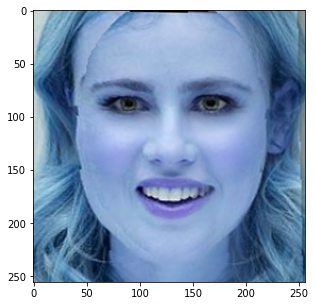

In [ ]:
plt.figure(figsize=(5,5))
plt.imshow(faces_dlib_test[0])

# print('Nombre de faces détectées par dlib: ', len(faces_dlib))
# print('Nombre de labels dlib: ', len(labels_dlib))



# i = 0
# plt.figure(figsize=(10,10))
# plt.subplot(131)
# plt.imshow(faces_dlib[i])
# plt.subplot(132)
# plt.imshow(faces_dlib[i+1])
# plt.subplot(133)
# plt.imshow(faces_dlib[i+2])

In [ ]:
len(faces_dlib_test)

1

100%|██████████| 1/1 [00:00<00:00, 150.31it/s]


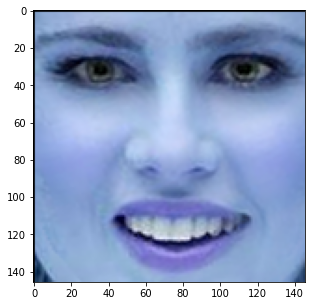

In [ ]:
faces_ilbp,labels_ilbp  = Visage_detect_cascade(faces_dlib_test,labels_dlib_test)
plt.figure(figsize=(5,5))
plt.imshow(faces_ilbp[0])


In [ ]:
len(faces_ilbp)

630

#  Save faces 

In [ ]:
def Saveface(Imgs, labels, path):
  folders = os.listdir(path)
  for l in folders:
    j = 0
    for i in range(len(Imgs)):
      if l==labels[i]:
        cv2.imwrite(f'{path}/{l}/{labels[i]}{j}.jpg' ,Imgs[i])
        j+=1
  return      


In [ ]:
#Saveface(faces_ilbp,labels_ilbp,'/content/drive/MyDrive/Projet S2/dataset3/Data_ANN/Data/faces_ilbp_test')

In [ ]:
#  liens images et labels
paths_train, labels_train = _get_data('/content/drive/MyDrive/Projet S2/dataset3/Data_ANN/Data/faces_ilbp_test')


print('Nombre de liens images: ', len(paths_train))
print('Nombre de liens images: ', len(labels_train))


Nombre de liens images:  630
Nombre de liens images:  630


In [ ]:
# k_img, k_labs = _get_data('/content/drive/MyDrive/Projet S2/faces_dlib_train')


# print('Nombre de faces détectées par dlib: ', len(k_img))
# print('Nombre de labels dlib: ', len(k_labs))

### 3. Visages coupés avec ILBPcascade 

In [ ]:
# faces_ilbp,labels_ilbp  = Visage_detect_cascade(faces_dlib,labels_dlib)


def open_faces(imgs_paths, labels):
  imgs = []
  #labels = []
  for k in tqdm(range(len(imgs_paths))):
    imgs.append(cv2.imread(imgs_paths[k]))
  return imgs, labels   



In [ ]:

faces_ilbp,labels_ilbp =  open_faces(faces_dlib,labels_dlib )


In [ ]:

print('Nombre de faces détectées par ILBPcascade: ', len(faces_ilbp))
print('Nombre de labels ILBPcascade: ', len(labels_ilbp))


i = 200
plt.figure(figsize=(10,10))
plt.subplot(131)
plt.imshow(faces_ilbp[i])
plt.subplot(132)
plt.imshow(faces_ilbp[i+1])
plt.subplot(133)
plt.imshow(faces_ilbp[i+2])

In [ ]:
# Saveface(faces_ilbp,labels_ilbp,'/content/drive/MyDrive/Projet S2/faces_ilbp_train')


# k_img, k_labs = _get_data('/content/drive/MyDrive/Projet S2/faces_ilbp_train')


# print('Nombre de faces détectées par dlib: ', len(k_img))
# print('Nombre de labels dlib: ', len(k_labs))

### 4. Extraction de caractéristiques HOG

In [ ]:

features_train, hog_im1 = Hog_feats(faces_ilbp)


In [ ]:
i = 0
plt.figure(figsize=(10,10))
plt.subplot(131)
plt.imshow(hog_im1[i])
plt.subplot(132)
plt.imshow(hog_im1[i+1])
plt.subplot(133)
plt.imshow(hog_im1[i+2])

## Données test

### 1. Récuperation des liens images et labels

In [ ]:
# #  liens images et labels
# paths_test, labels_test =_get_data('/content/drive/MyDrive/Projet S2/dataset3/test/Musique')


# print('Nombre de liens images: ', len(paths_test))
# print('Nombre de liens images: ', len(labels_test))





### 2. Detection de visages avec dlib et frontalisation

In [ ]:
# faces_dlib_test,labels_dlib_test = face(paths_test, labels_test)

faces_dlib_test,labels_dlib_test  = _get_data('/content/drive/MyDrive/Projet S2/faces_ilbp_test')


print('paths test images: ', len(faces_dlib_test))

print('labels test : ',len(labels_dlib_test))

In [ ]:
# # print('Nombre de faces détectées par fronatalisation: ', len(faces_dlib_test))
# # print('Nombre de labels fronatalisation: ', len(labels_dlib_test))


# i = 200
# plt.figure(figsize=(10,10))
# plt.subplot(131)
# plt.imshow(faces_dlib_test[i])
# plt.subplot(132)
# plt.imshow(faces_dlib_test[i+1])
# plt.subplot(133)
# plt.imshow(faces_dlib_test[i+2])


In [ ]:
# Saveface(faces_dlib_test,labels_dlib_test,'/content/drive/MyDrive/Projet S2/faces_dlib_test')


# k_img, k_labs = _get_data('/content/drive/MyDrive/Projet S2/faces_dlib_test')


# print('Nombre de faces détectées par dlib: ', len(k_img))
# print('Nombre de labels dlib: ', len(k_labs))

### 3. Visages coupés avec ILBPcascade

In [ ]:
# faces_ilbp_test,labels_ilbp_test  = Visage_detect_cascade(faces_dlib_test,labels_dlib_test)


faces_ilbp_test,labels_ilbp_test  = open_faces(faces_dlib_test,labels_dlib_test)

In [ ]:
print('Nombre de faces détectées par ILBPcascade: ', len(faces_ilbp_test))
print('Nombre de labels ILBPcascade: ', len(labels_ilbp_test))


i = 20
plt.figure(figsize=(10,10))
plt.subplot(131)
plt.imshow(faces_ilbp_test[i])
plt.subplot(132)
plt.imshow(faces_ilbp_test[i+1])
plt.subplot(133)
plt.imshow(faces_ilbp_test[i+2])

In [ ]:
# Saveface(faces_ilbp_test,labels_ilbp_test,'/content/drive/MyDrive/Projet S2/faces_ilbp_test')


# k_img, k_labs = _get_data('/content/drive/MyDrive/Projet S2/faces_ilbp_test')


# print('Nombre de faces détectées par dlib: ', len(k_img))
# print('Nombre de labels dlib: ', len(k_labs))

### 4. Extraction de caractéristiques HOG

In [ ]:
features_test, hog_img_test = Hog_feats(faces_ilbp_test)

In [ ]:
i = 0
plt.figure(figsize=(10,10))
plt.subplot(131)
plt.imshow(hog_img_test[i])
plt.subplot(132)
plt.imshow(hog_img_test[i+1])
plt.subplot(133)
plt.imshow(hog_img_test[i+2])

# Models SVM et leur Accuracy

### SVM ovr

In [ ]:

from sklearn.metrics  import accuracy_score
from sklearn.multiclass import OneVsRestClassifier


    #  SVM models 
model_rbf31 = SVC(kernel='rbf', decision_function_shape = "ovr")
model_poly31 = SVC(kernel='poly', decision_function_shape = "ovr", degree = 4)
model_linear31 = SVC(kernel='linear', decision_function_shape = "ovr")

model_sc31 = OneVsRestClassifier(LinearSVC(max_iter=100000))


#     #  Entrainnement de models 
rbf = model_rbf31.fit(features_train, np.array(labels_ilbp))
linear = model_linear31.fit(features_train, np.array(labels_ilbp))
poly = model_poly31.fit(features_train, np.array(labels_ilbp))
mod = model_sc31.fit(features_train, np.array(labels_ilbp))



In [ ]:
import pickle 
filename = 'rgb_frontalize_ovr.sav'
pickle.dump(rbf, open(filename, 'wb'))
 
 
filename1 = 'poly_frontalize_ovr.sav'
pickle.dump(poly, open(filename1, 'wb'))

filename2 = 'linear_frontalize_ovr.sav'
pickle.dump(linear, open(filename2, 'wb'))

filename1 = 'LinearSVC_frontalize_ovr.sav'
pickle.dump(mod, open(filename1, 'wb'))


In [ ]:
    
# #     #  Prediction     
rbf_predict31 = rbf.predict(features_test)
poly_predict31 = poly.predict(features_test)
linear_predict31 = linear.predict(features_test)
sc_predict31 = mod.predict(features_test)



In [ ]:
from sklearn.metrics  import classification_report

print(classification_report(rbf_predict31, labels_ilbp_test))



In [ ]:
print(classification_report(poly_predict31, labels_ilbp_test))



In [ ]:
print(classification_report(linear_predict31, labels_ilbp_test))



In [ ]:
print(classification_report(sc_predict31, labels_ilbp_test))



# Filtrage 

In [ ]:
def median(imgs):
  Vs = []
  for i in range(len(imgs)):
    k = cv2.medianBlur(imgs[i],3)
    Vs.append(k)
  return Vs 

# S = median(I2)    

In [ ]:
                #   Train


#  faces_ilbp,labels_ilbp 



faces_ilbp = median(faces_ilbp)

features_train,jjj = Hog_feats(faces_ilbp)




In [ ]:
print(len(faces_ilbp))
print(len(labels_ilbp ))

In [ ]:
            #   Test 

#  faces_ilbp_test,labels_ilbp_test

faces_ilbp_test = median(faces_ilbp_test)

features_test,lll = Hog_feats(faces_ilbp_test)


In [ ]:
##   SVM ovr

from sklearn.metrics  import accuracy_score
from sklearn.multiclass import OneVsRestClassifier


    #  SVM models 
model_rbf31 = SVC(kernel='rbf', decision_function_shape = "ovr")
model_poly31 = SVC(kernel='poly', decision_function_shape = "ovr", degree = 4)
model_linear31 = SVC(kernel='linear', decision_function_shape = "ovr")

model_sc31 = OneVsRestClassifier(LinearSVC(max_iter=100000))


#     #  Entrainnement de models 
rbf_front_filt = model_rbf31.fit(features_train, np.array(labels_ilbp))
linear_front_filt = model_linear31.fit(features_train, np.array(labels_ilbp))
poly_front_filt = model_poly31.fit(features_train, np.array(labels_ilbp))
mod_front_filt = model_sc31.fit(features_train, np.array(labels_ilbp))





In [ ]:
# # ##  Save model SVL ovr
import pickle

filename = 'rgb_frontalize_filtre_ovr.sav'
pickle.dump(rbf_front_filt, open(filename, 'wb'))
 
 
filename1 = 'poly_frontalize_filtre_ovr.sav'
pickle.dump(poly_front_filt, open(filename1, 'wb'))

filename2 = 'linear_frontalize_filtre_ovr.sav'
pickle.dump(linear_front_filt, open(filename2, 'wb'))

filename1 = 'LinearSVC_frontalize_filtre_ovr.sav'
pickle.dump(mod_front_filt, open(filename1, 'wb'))



In [ ]:
     
# #     #  Prediction     
rbf_predict31 = rbf_front_filt.predict(features_test)
poly_predict31 = poly_front_filt.predict(features_test)
linear_predict31 = linear_front_filt.predict(features_test)
sc_predict31 = mod_front_filt.predict(features_test)



from sklearn.metrics  import classification_report


In [ ]:
print(classification_report(rbf_predict31, labels_ilbp_test))



In [ ]:
print(classification_report(poly_predict31, labels_ilbp_test))




In [ ]:
print(classification_report(linear_predict31, labels_ilbp_test))



In [ ]:
print(classification_report(sc_predict31, labels_ilbp_test))



# GridSearch

In [ ]:

X_train, y_train = features_train, labels_ilbp 

In [ ]:
from sklearn.model_selection import GridSearchCV

# defining parameter range
param_grid = {'C': [0.1, 1, 10,50, 100,1000],
			'gamma': [10,5, 0.1, 0.01, 0.001],
			'kernel': ['rbf', 'poly'],
     # 'degree':[2,3,4,5,6,10,12,15]
			}

grid = GridSearchCV(SVC(), param_grid, refit = True,scoring= 'accuracy', cv = 2, verbose = 3)

# fitting the model for grid search
grid.fit(X_train, y_train)


Fitting 2 folds for each of 60 candidates, totalling 120 fits
[CV 1/2] END .......C=0.1, gamma=10, kernel=rbf;, score=0.016 total time=  37.4s
[CV 2/2] END .......C=0.1, gamma=10, kernel=rbf;, score=0.016 total time=  37.4s
[CV 1/2] END ......C=0.1, gamma=10, kernel=poly;, score=0.821 total time=  28.0s
[CV 2/2] END ......C=0.1, gamma=10, kernel=poly;, score=0.831 total time=  28.3s
[CV 1/2] END ........C=0.1, gamma=5, kernel=rbf;, score=0.016 total time=  35.6s
[CV 2/2] END ........C=0.1, gamma=5, kernel=rbf;, score=0.016 total time=  35.6s
[CV 1/2] END .......C=0.1, gamma=5, kernel=poly;, score=0.821 total time=  27.8s
[CV 2/2] END .......C=0.1, gamma=5, kernel=poly;, score=0.831 total time=  27.9s
[CV 1/2] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.016 total time=  35.3s
[CV 2/2] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.016 total time=  35.2s
[CV 1/2] END .....C=0.1, gamma=0.1, kernel=poly;, score=0.821 total time=  27.7s
[CV 2/2] END .....C=0.1, gamma=0.1, kernel=poly

GridSearchCV(cv=2, estimator=SVC(),
             param_grid={'C': [0.1, 1, 10, 50, 100, 1000],
                         'gamma': [10, 5, 0.1, 0.01, 0.001],
                         'kernel': ['rbf', 'poly']},
             scoring='accuracy', verbose=3)

In [ ]:
print(grid.best_estimator_)
print(grid.best_params_)
print(grid.best_score_)

SVC(C=100, gamma=0.001)
{'C': 100, 'gamma': 0.001, 'kernel': 'rbf'}
0.8348149747810866


In [ ]:
filenam = 'grid_best_estimator.sav'
pickle.dump(grid.best_estimator_, open(filenam, 'wb'))
 

# Prédiction